In [1]:
#%matplotlib inline
import ROOT
ROOT.gSystem.Load("/mnt/c/Users/marratia/Linux/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, cout
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
#plotting, style
from matplotlib import pyplot as plt
ROOT.gStyle.SetOptStat('')
from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex
SetAtlasStyle()
ROOT.gStyle.SetPalette(ROOT.kViridis);


Welcome to JupyROOT 6.09/01


/root/myROOT/lib/ROOT.py:432: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


### Get Data and MC files

In [2]:
Datafile = ROOT.TFile('OutputData/fout_16_13b_pass4_v2_3run.root')
MCfile = ROOT.TFile('OutputData/fout_16_17g6a3_pthat2_latest.root')
filedata = ROOT.TFile('HEPData.root','READ')
published_data = filedata.Get('hTrack_HEP')

### Get response Matrix and plot it, also true/reco ratio

Info in <TCanvas::Print>: png file Matrix.png has been created


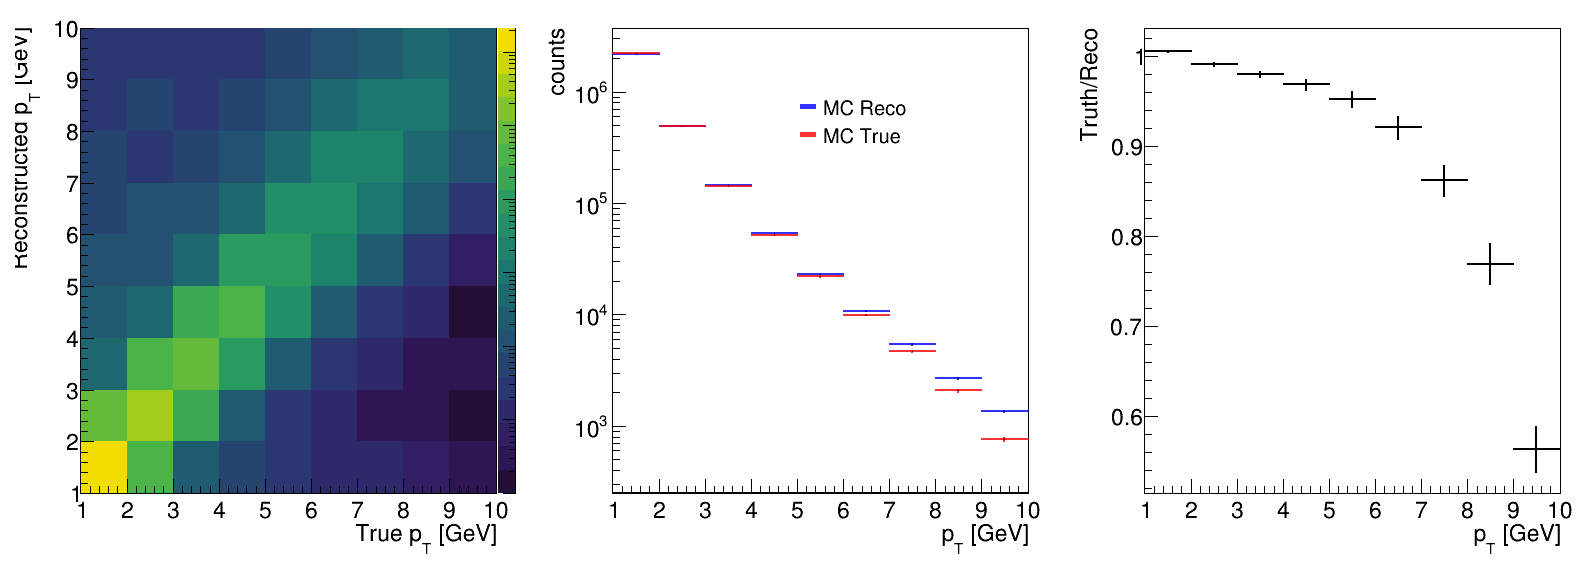

In [3]:
responseMatrix = MCfile.Get("hCorrelation");
#responseMatrix.Rebin2D(2,2)
responseMatrix.ClearUnderflowAndOverflow()
mc_truth = responseMatrix.ProjectionX()
mc_reco = responseMatrix.ProjectionY()
mc_truth.Sumw2()
mc_reco.Sumw2()
mc_truth.SetLineColorAlpha(2,0.8)
mc_reco.SetLineColorAlpha(4,0.8)

##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(3)
c.cd(1)
responseMatrix.Draw('colz')
ROOT.gPad.SetLogz()
c.cd(2)

label = Legend("")
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

hs_mc = ROOT.THStack()
hs_mc.Add(mc_reco)
hs_mc.Add(mc_truth)
hs_mc.Draw('nostack')
hs_mc.SetTitle('; p_{T} [GeV]; counts')

label.Draw(0.5,.87)
ROOT.gPad.SetLogy()
c.cd(3)
ratio_mc = mc_truth.Clone()
ratio_mc.SetLineColor(1)
ratio_mc.Divide(mc_reco)
ratio_mc.Draw('L')
ratio_mc.SetTitle(' ; p_{T} [GeV]; Truth/Reco')
c.Draw()
c.SaveAs('Matrix.png')

### Get measured track pt spectrum

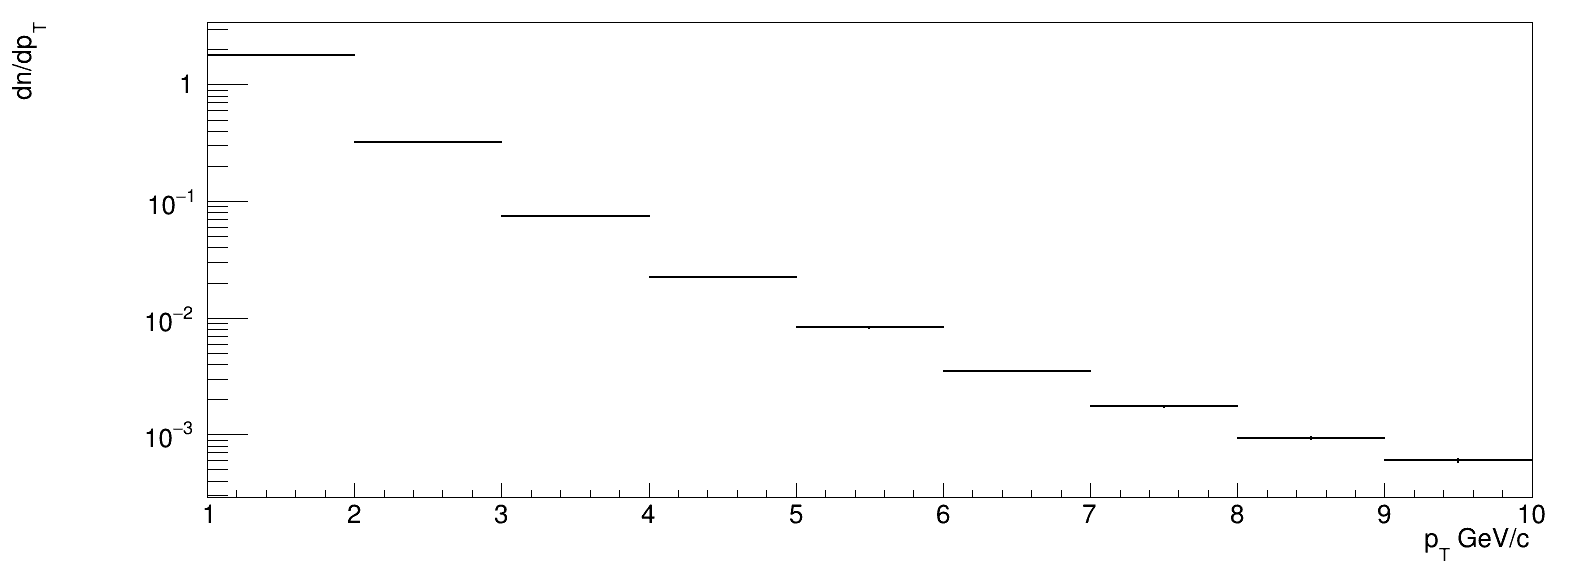

In [4]:
data = Datafile.Get('track_pt')
data.ClearUnderflowAndOverflow()

c.Clear()
data.Draw()
ROOT.gPad.SetLogy()
c.Draw()

### Get and plot efficiency and fake rate

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file EfficiencyAndFakeRate.png has been created


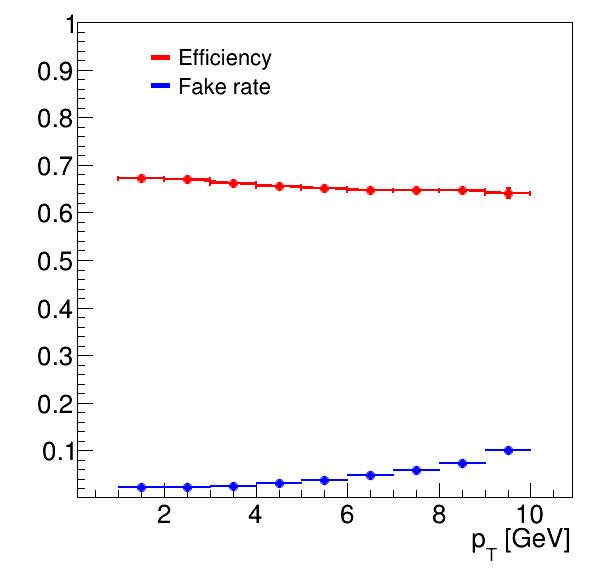

In [5]:
#Get efficiency and fake rate
efficiency = MCfile.Get("Efficiency");
fakerate   = MCfile.Get("FakeRate");

#Plot efficiency and fake rate
efficiency.SetTitle(' ; p_{T} [GeV]')
efficiency.SetMinimum(0.0)
efficiency.SetMaximum(1.0)
efficiency.SetMarkerStyle(20)
efficiency.SetMarkerColor(2)
efficiency.SetLineColor(2)
fakerate.SetMarkerStyle(20)
fakerate.SetLineColor(4)
fakerate.SetMarkerColor(4)

c = ROOT.TCanvas('c','c',600,600)
efficiency.Draw()
fakerate.Draw('same')

label = Legend("")
label.Add(efficiency,'Efficiency','L')
label.Add(fakerate,'Fake rate','L')
label.Draw(.25,.95)
c.Draw()
c.SaveAs('EfficiencyAndFakeRate.png')

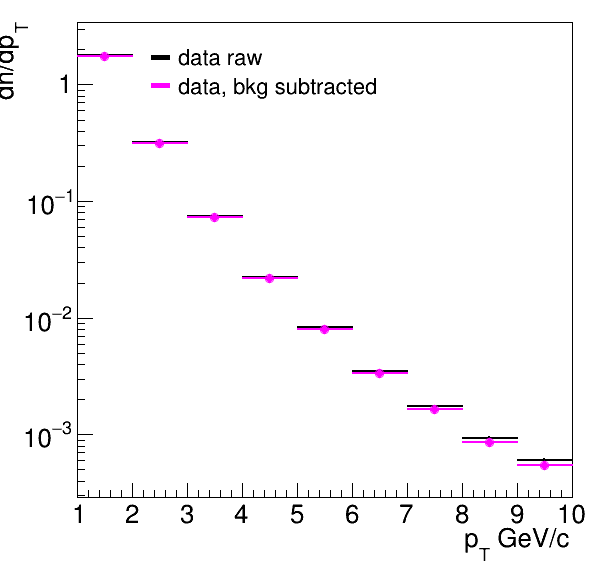

In [6]:
data_bkgsub = data.Clone()
for i in range(1,fakerate.GetNbinsX()+1):
    bkg = data.GetBinContent(i)*fakerate.GetBinContent(i)
    data_bkgsub.SetBinContent(i,data.GetBinContent(i)-bkg)

c.Clear()
data.Draw()
data_bkgsub.SetLineColor(ROOT.kMagenta)
data_bkgsub.SetMarkerColor(ROOT.kMagenta)
data_bkgsub.SetMarkerStyle(20)

data_bkgsub.Draw('same')
ROOT.gPad.SetLogy()
label = Legend("")
label.Add(data,'data raw','L')
label.Add(data_bkgsub,'data, bkg subtracted','L')
label.Draw(.25,.95)
c.Draw()


### DEFINE DATA FOR UNFOLDING 

In [69]:
data_inputforunfolding = data_bkgsub.Clone()
#data_inputforunfolding = data.Clone()

### UNFOLDING 

In [70]:
response= RooUnfoldResponse(mc_reco, mc_truth, responseMatrix)
response.UseOverflow(ROOT.kTRUE)
data_unfolded = {}
#for tau in range(4,6):
#    data_unfolded['SVD%i'%tau] = RooUnfoldSvd(response, data_inputforunfolding, tau).Hreco();
   
data_unfolded['SVD4'] = RooUnfoldSvd(response, data_inputforunfolding, 4).Hreco();
data_unfolded['SVD5'] = RooUnfoldSvd(response, data_inputforunfolding, 5).Hreco();

print data_unfolded

SVD init 11 x 11 bins, kreg=4
SVD init 11 x 11 bins, kreg=5
{'SVD5': <ROOT.TH1D object ("hCorrelation") at 0x7fffe2961a90>, 'SVD4': <ROOT.TH1D object ("hCorrelation") at 0x7fffe2911460>}


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 4
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000000
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 5
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000000


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Unfoldedresult.png has been created


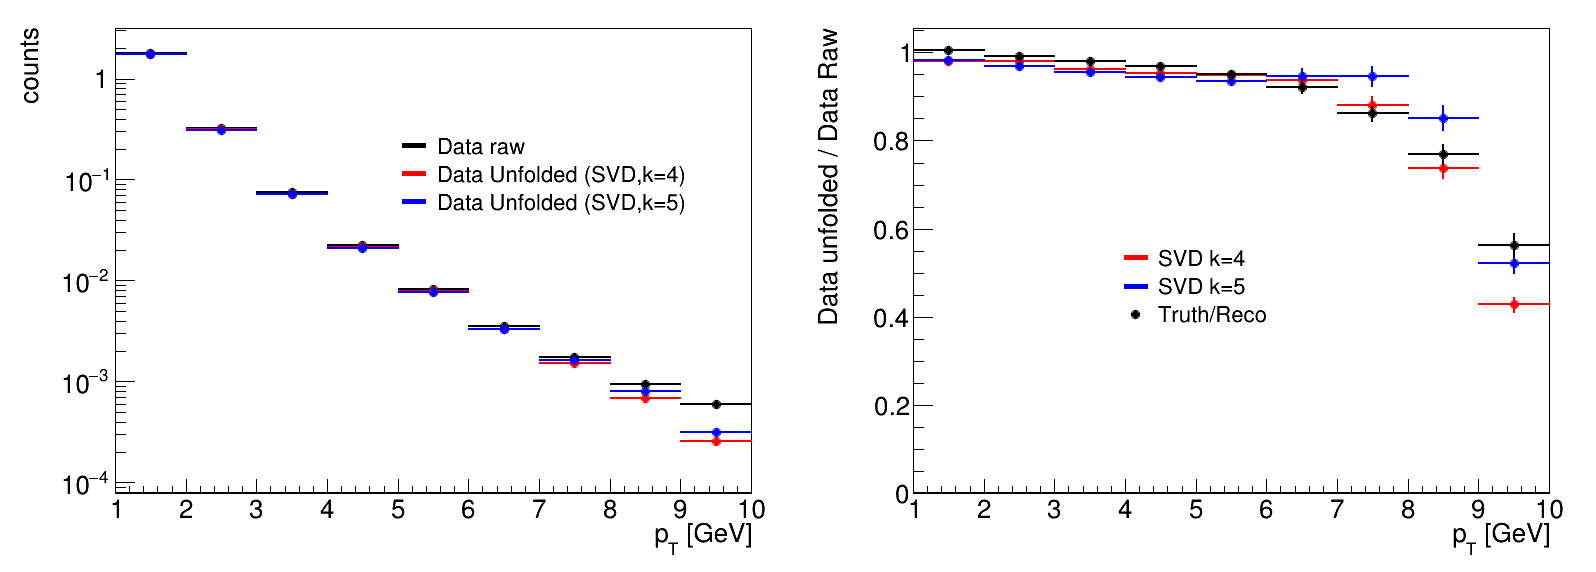

In [71]:
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(2)
c.cd(1)
label = Legend("")

hstack = ROOT.THStack()
hstack.Add(data)
label.Add(data,'Data raw','L')

data.SetMarkerStyle(20)
data_unfolded['SVD4'].SetLineColor(2)
data_unfolded['SVD4'].SetMarkerColor(2)
data_unfolded['SVD4'].SetMarkerStyle(20)
data_unfolded['SVD5'].SetLineColor(4)
data_unfolded['SVD5'].SetMarkerColor(4)
data_unfolded['SVD5'].SetMarkerStyle(20)

hstack.Add(data_unfolded['SVD4'])
hstack.Add(data_unfolded['SVD5'])
label.Add(data_unfolded['SVD4'], 'Data Unfolded (SVD,k=4)','L')
label.Add(data_unfolded['SVD5'], 'Data Unfolded (SVD,k=5)','L')
               
hstack.SetTitle('; p_{T} [GeV]; counts')
hstack.Draw('nostack')
ROOT.gPad.SetLogy()
label.Draw(.5,.8)
c.cd(2)

hs_ratio = ROOT.THStack()
label = Legend("")

ratio = {}
ratio['SVD4'] = data_unfolded['SVD4'].Clone()
ratio['SVD4'].Divide(data) 
ratio['SVD5'] = data_unfolded['SVD5'].Clone()
ratio['SVD5'].Divide(data) 

hs_ratio.Add( ratio['SVD4'])
hs_ratio.Add( ratio['SVD5'])

label.Add(ratio['SVD4'],'SVD k=4','L')
label.Add(ratio['SVD5'],'SVD k=5','L')

#simple bin-by-bin unfolding
ratio_mc.SetMarkerStyle(20)
ratio_mc.SetMarkerSize(1)
ratio_mc.SetMarkerColor(1)

hs_ratio.Add(ratio_mc)

hs_ratio.SetTitle('; p_{T} [GeV]; Data unfolded / Data Raw')
hs_ratio.Draw('nostack')
label.Add(ratio_mc, 'Truth/Reco','P')
label.Draw(.4,.6)
c.Draw()
c.SaveAs('Unfoldedresult.png')

#Correcting for efficiency


In [ ]:
##EFFICIENCY CORRECTION

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file UnfoldedSpectraAndPublishedResult.png has been created


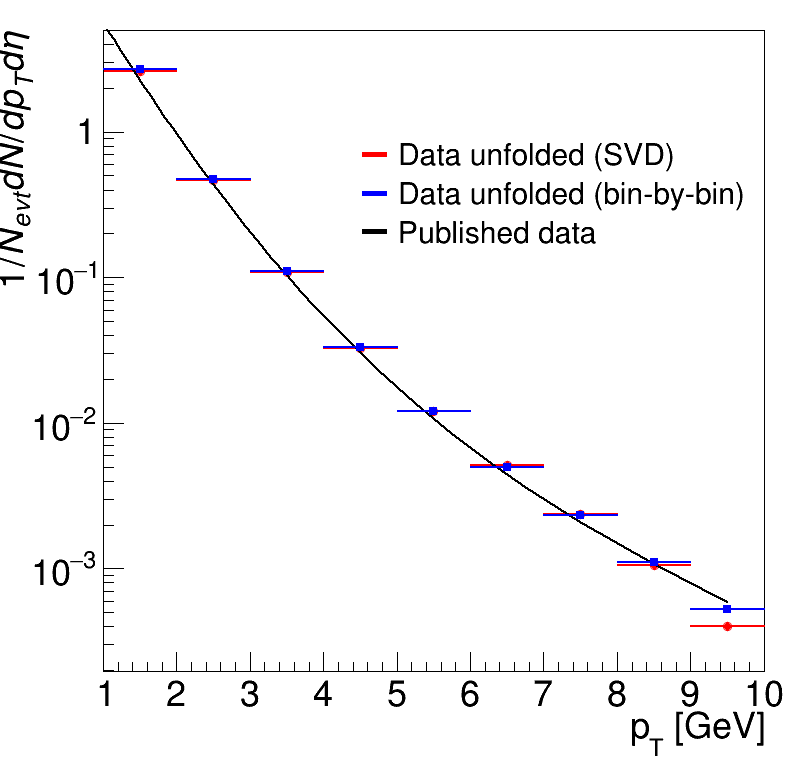

In [87]:
#efficiency.Print()
#applying efficiency
def applyEfficiencyCorrection(histo):
    histo_corrected = histo.Clone()
    for i in range(1,histo.GetNbinsX()+1):
        pt = ROOT.Double()
        eff = ROOT.Double()
        efficiency.GetPoint(i-1,pt,eff)
        #print pt, eff
        histo_corrected.SetBinContent(i,histo.GetBinContent(i)/eff)
        histo_corrected.SetBinError(i,histo.GetBinError(i)/eff)
    return histo_corrected


data_unfolded_SVD_4_corrected = applyEfficiencyCorrection(data_unfolded['SVD4'])
data_unfolded_SVD_5_corrected = applyEfficiencyCorrection(data_unfolded['SVD5'])

data_corrected = data.Clone()
data_onlyeff   = data.Clone()

data_corrected.Multiply(ratio_mc) #applying "naive unfolding"
data_onlyeff = applyEfficiencyCorrection(data_onlyeff)


data_corrected= applyEfficiencyCorrection(data_corrected)
c= ROOT.TCanvas('c','c',800,800)
#c.Divide(2)
#c.cd(1)
data_unfolded_SVD_4_corrected.SetTitle('; p_{T} [GeV]; 1/N_{evt} dN/dp_{T}d\eta')
data_unfolded_SVD_4_corrected.SetMarkerStyle(20)
data_unfolded_SVD_4_corrected.SetMarkerColor(2)
data_unfolded_SVD_4_corrected.Draw()
data_unfolded_SVD_5_corrected.SetMarkerStyle(21)
data_unfolded_SVD_5_corrected.SetMarkerColor(ROOT.kOrange+1)
data_unfolded_SVD_5_corrected.SetLineColor(ROOT.kOrange+1)
#data_unfolded_SVD_5_corrected.Draw('same')
published_data.Draw('histLsame')
data_corrected.SetTitle('; p_{T} [GeV]; 1/N_{evt} dN/dp_{T}d\eta')
data_corrected.SetMarkerColor(4)
data_corrected.SetLineColor(4)
#data_corrected.Draw('histsame')
data_corrected.SetMarkerStyle(21)
data_onlyeff.SetLineColor(3)
data_onlyeff.SetMarkerColor(3)
data_onlyeff.SetMarkerStyle(21)
#data_onlyeff.Draw('histsame')
data_corrected.SetMarkerStyle(21)
data_corrected.Draw('same')

label = Legend("")
label.Add(data_unfolded_SVD_4_corrected,'Data unfolded (SVD)','L')
label.Add(data_corrected,'Data unfolded (bin-by-bin)','L')
#label.Add(data_unfolded_SVD_5_corrected,'Data unfolded (SVD k=5) + eff corr.','L')
label.Add(published_data,'Published data','L')
#label.Add(data_onlyeff,'Data + eff corr.','L')
#label.Add(data_corrected,'Data unfolded (bin-by-bin) + eff corr.','L')
label.Draw(.45,.85)

ROOT.gPad.SetLogy()



c.SaveAs('UnfoldedSpectraAndPublishedResult.png')
c.Draw()

In [88]:
def printHisto(histo):
    values = []
    for i in range(1,histo.GetNbinsX()+1):
        width = histo.GetBinWidth(i)/2.0
        center = histo.GetBinCenter(i)
        content = histo.GetBinContent(i)
        #print '%2.2f--%2.2f = %2.5f, %2.5f' %(center-width,center+width,content, content*width*2.0)
        #print '%2.5f' %(content*width*2.0)
        #print '%2.2f--%2.2f' %(center-width,center+width)
        #print '%2.5f' %(content)
        values.append(content)
    print ' '
    return values


In [89]:
binned_data = [2.6184, 0.48494, 0.11142, 0.0319, 0.01104, 0.00453,0.00208, 0.00106, 0.00059]#,0.00035,0.000216321]
h = ROOT.TH1F('binned_data','',len(binned_data),1.0,10.0)
for i in range(len(binned_data)):
    #print i, ' ' , binned_data[i]
    h.SetBinContent(i+1,binned_data[i])
    h.SetBinError(i+1,0.0)

Warning in <TFile::Append>: Replacing existing TH1: binned_data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: binned_data (Potential memory leak).


In [90]:
ratio_data_unfolded_SVD_4_corrected = data_unfolded_SVD_4_corrected.Clone()
ratio_data_unfolded_SVD_5_corrected = data_unfolded_SVD_5_corrected.Clone()
ratio_data_corrected                = data_corrected.Clone()
ratio_unity                         = h.Clone()

ratio_data_unfolded_SVD_4_corrected.Divide(h)
ratio_data_unfolded_SVD_5_corrected.Divide(h)
ratio_data_corrected.Divide(h)
ratio_unity.Divide(h)

True

Warning in <TH1D::Divide>: Dividing histograms with different bin limits
Warning in <TH1D::Divide>: Dividing histograms with different bin limits
Warning in <TH1F::Divide>: Dividing histograms with different bin limits


In [91]:
ratio_data_raw = data.Clone()
ratio_data_raw.Divide(h)
ratio_data_bkgsub = data_bkgsub.Clone()
ratio_data_bkgsub.Divide(h)

ratio_data_unfoldedSVD4 = data_unfolded['SVD4'].Clone()
ratio_data_unfoldedSVD4.Divide(h)


True

Warning in <TH1F::Divide>: Dividing histograms with different bin limits
Warning in <TH1F::Divide>: Dividing histograms with different bin limits
Warning in <TH1D::Divide>: Dividing histograms with different bin limits


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Comparison_Unfolded.png has been created


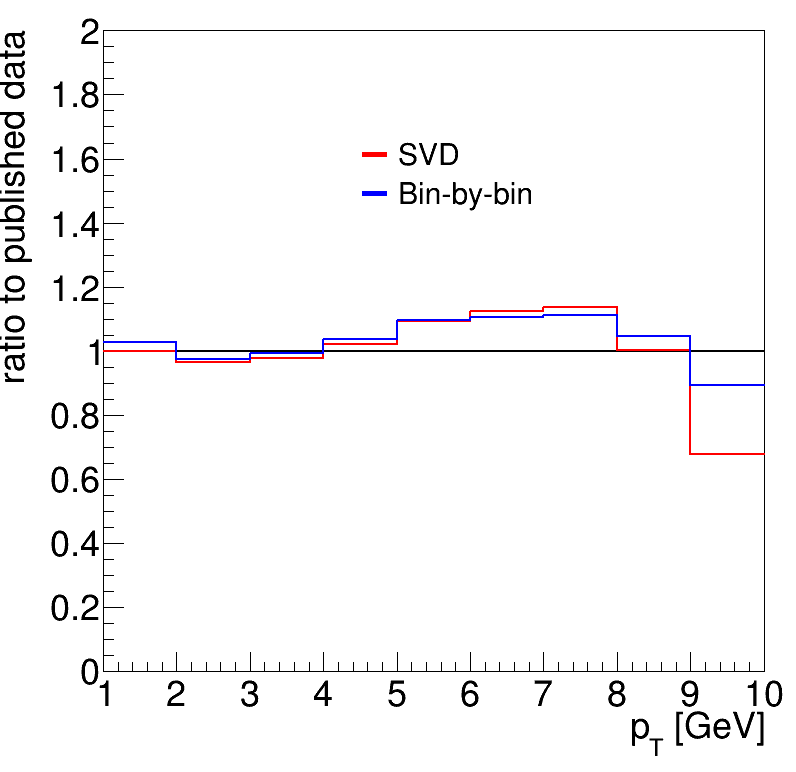

In [98]:
c= ROOT.TCanvas('c','c',800,800)


ratio_unity.Draw("histsame")
ratio_unity.SetTitle('; p_{T} [GeV]; ratio to published data')
ratio_unity.SetTitle('Data unfolded / Published data')
ratio_unity.SetMaximum(2.0)
ratio_unity.SetMinimum(0.0)
ratio_data_unfolded_SVD_4_corrected.Draw('histsame')
#ratio_data_unfolded_SVD_5_corrected.Draw('histsame')
ratio_data_corrected.Draw('histsame')
#ratio_data_raw.Draw("histsame")
#ratio_data_bkgsub.Draw("histsame")
#ratio_data_unfoldedSVD4.Draw("histsame")

label = Legend("")
label.Add(ratio_data_unfolded_SVD_4_corrected,'SVD','L')
#label.Add(ratio_data_unfolded_SVD_5_corrected,'SVD k=5 + eff corr.','L')
label.Add(ratio_data_corrected,'Bin-by-bin','L')
label.Draw(.45,.85)

c.Draw()
c.SaveAs('Comparison_Unfolded.png')
